In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/fastai/fastai
!pip install -e "fastai[dev]"

In [3]:
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/programmers/data/train.zip' -d '/content'
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/programmers/data/test.zip' -d '/content'

# 프로그래머스 과제관 - 미술 작품 분류

**데이터 설명**
- 데이터 셋은 art painting으로 구성되어 있으며 7개의 카테고리로 구분되어 있습니다.
- 7개의 카테고리로는 classes에서 정의한 dog, elephant, giraffe, guitar, horse, house, person를 포함합니다.
- 하나의 이미지의 사이즈는 [3(Channel) * 227(Width) * 227(Height)]이며 각 - - 카테고리 별 예시 이미지는 아래에서 확인할 수 있습니다.
- 훈련 데이터는 art painting 1698장이며 테스트 데이터는 art painting 350장입니다.

In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

import warnings
warnings.filterwarnings('ignore')

import platform
import sys
import os
import sklearn 
import cv2
import json
from glob import glob
# from shutil import copyfile
from sklearn.model_selection import StratifiedKFold

#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

import torch
from torchvision import models
from torch.utils.data import Dataset
from torchvision.models.efficientnet import efficientnet_b0
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score #, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from fastai.vision.all import *
# from fastai.tabular import *

class config:
    seed = 42
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
    lr = 3e-3
    epochs = 30
    batch_size = 16
    # num_workers = 4
    patience = 5
    min_delta = 0.01
    dropout= 0.1
    optimizer = 'Adam'
    train_5_folds = True
    num_fold = 5
    scheduler = ''

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(config.seed)
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")
print(f"- os: {platform.platform()}")
print(f"- python: {sys.version}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- sklearn: {sklearn.__version__}")
print(f"- pytorch: {torch.__version__}")
print(f"- opencv: {cv2.__version__}")

Setup complete. Using torch 1.10.0+cu111 (Tesla P100-PCIE-16GB)
- os: Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic
- python: 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
- pandas: 1.3.5
- numpy: 1.19.5
- sklearn: 1.0.2
- pytorch: 1.10.0+cu111
- opencv: 4.1.2


## 데이터 로드
* dataloader에 이미지 경로와 라벨 정보를 넣어주기 위해 glob 모듈을 이용하여 모든 경로를 가져옴. 
* 가져온 경로를 이용하여 경로와 라벨을 데이터 프레임으로 만듦.
* 5fold를 하기위해 fold 열 추가

In [2]:
TRAIN_PATH = '/content/train/'
classes = ['dog', 'elephant', 'giraffe','guitar','horse','house','person']

In [3]:
train_jpg = glob.glob(TRAIN_PATH+'*/*.jpg')
df_train = pd.DataFrame()
df_train['dir'] = train_jpg
df_train['labels'] = df_train.dir.apply(lambda x: x.split('/')[3])
df_train['fold']=0
df_train

dir  labels  fold
0      /content/train/house/pic_251.jpg   house     0
1      /content/train/house/pic_087.jpg   house     0
2      /content/train/house/pic_072.jpg   house     0
3      /content/train/house/pic_004.jpg   house     0
4      /content/train/house/pic_046.jpg   house     0
...                                 ...     ...   ...
1693  /content/train/guitar/pic_070.jpg  guitar     0
1694  /content/train/guitar/pic_074.jpg  guitar     0
1695  /content/train/guitar/pic_001.jpg  guitar     0
1696  /content/train/guitar/pic_101.jpg  guitar     0
1697  /content/train/guitar/pic_022.jpg  guitar     0

[1698 rows x 3 columns]

### 구현 계획
- 1,698장의 적은 학습데이터셋: aug_transforms을 이용하여 데이터 증강
  - pad_mode는 zero, reflection, border가 있는데 border옵션이 가장 그림과 비슷한 효과를 주는 듯 하여 선택함
  - flip_vert=False (상하로 뒤집힌 것은 추가하지 않음)
  - 그림 특성상 색상이 다양하므로 xtra_tfms에 Saturation, Hue 변형 추가
  - 데이터 셋의 mean, std를 이용하여 정규화 수행

- 5-fold cross validation
  - StratifiedKFold로 나눈 fold 번호를 이용하여 매 fold에 해당하는 validation data의 인덱스를 리턴하는 splitter 함수를 정의하여 indexSplitter에 입력으로 넣어줌.
  - IndexSplitter는 valid index list를 받아서 train, valid data로 나누어주는 splitter
<br>

- CutMix, MixUp 등의 augmentation도 추가 실험
- aug_transforms 종류 : https://docs.fast.ai/vision.augment.html

## StratifiedKFold
- 클래스별 비율을 맞춰 train / validation set split

In [4]:
Fold = StratifiedKFold(n_splits=config.num_fold, shuffle=True, random_state=config.seed)

for n, (train_index, val_index) in enumerate(Fold.split(df_train, df_train.labels)):
    df_train.loc[val_index, 'fold'] = int(n)
df_train['fold'] = df_train['fold'].astype(int)
# df_train.to_csv('train_fold.csv', index=False)
df_train

dir  labels  fold
0      /content/train/house/pic_251.jpg   house     0
1      /content/train/house/pic_087.jpg   house     0
2      /content/train/house/pic_072.jpg   house     3
3      /content/train/house/pic_004.jpg   house     4
4      /content/train/house/pic_046.jpg   house     4
...                                 ...     ...   ...
1693  /content/train/guitar/pic_070.jpg  guitar     1
1694  /content/train/guitar/pic_074.jpg  guitar     4
1695  /content/train/guitar/pic_001.jpg  guitar     0
1696  /content/train/guitar/pic_101.jpg  guitar     0
1697  /content/train/guitar/pic_022.jpg  guitar     1

[1698 rows x 3 columns]

## datablock 생성

In [5]:
def get_x(df): return df['dir']
def get_y(df): return df['labels'].split(' ')
def splitter(df, num_fold:int):
    #train = df.index[df.fold==num_fold].tolist()
    valid = df.index[df['fold']!=num_fold].tolist()
    return valid

def get_dls(df, num_fold, bs:int=16, img_size:int=224):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                                splitter=IndexSplitter(splitter(df,num_fold)),
                                get_x = get_x,
                                get_y = get_y,
                                item_tfms = RandomResizedCrop(img_size, min_scale=.55), 
                                #RandomResizedCrop(img_size, min_scale=.75) # Resize(320, ResizeMethod.Pad, pad_mode='zeros') zero 패딩  
                                batch_tfms=[*aug_transforms(size=img_size, max_rotate=30.0, min_scale=0.5, pad_mode='border',
                                                            xtra_tfms=[Saturation(p=0.05, draw=0.0), Hue(p=0.05,draw=0.75), Hue(p=0.05, draw=1.5)],
                                                            ),
                                            Normalize, #mult=2변형정도 설정
                                          ])
                                                  #, Normalize.from_stats(*imagenet_stats)) # 이미지넷 mean std사용할떄
    return dblock.dataloaders(df, bs=bs) 


## 배치 이미지 확인

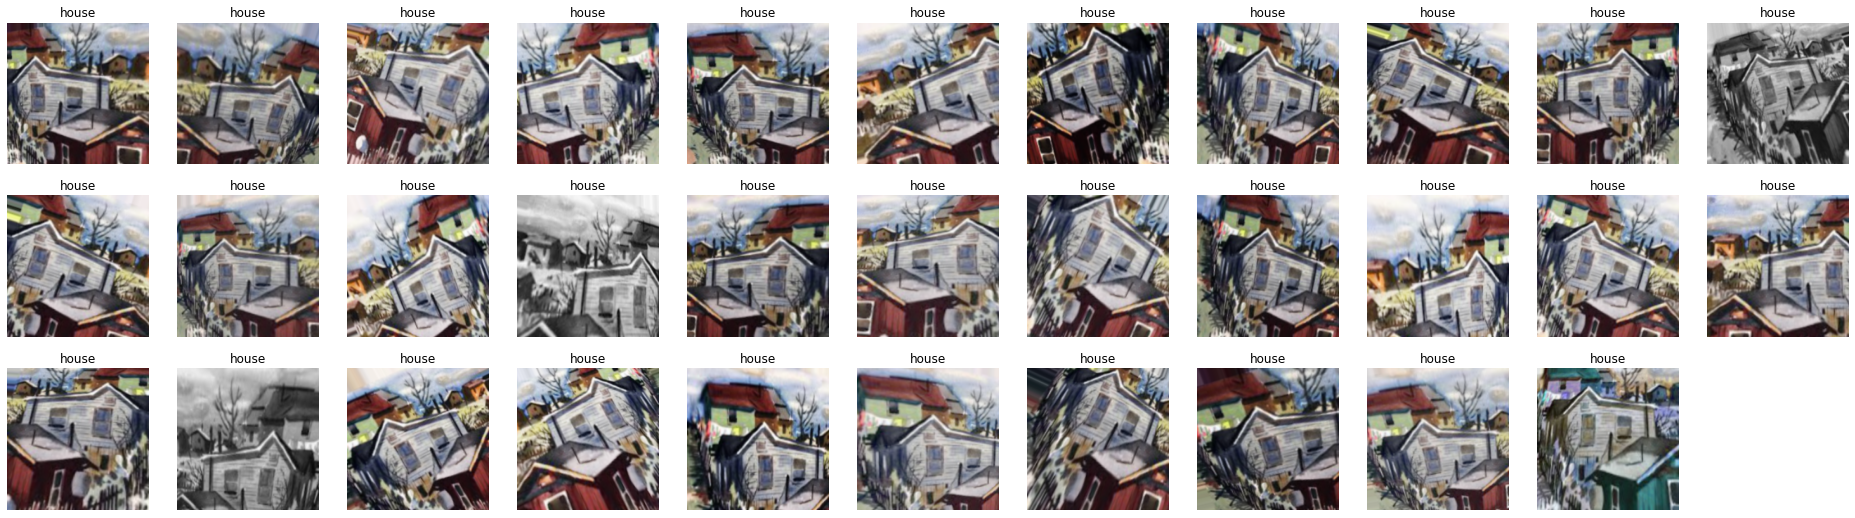

In [6]:
dls = get_dls(df_train, num_fold=0, bs=32)
dls.train.show_batch(max_n=32, nrows=3, unique=True)

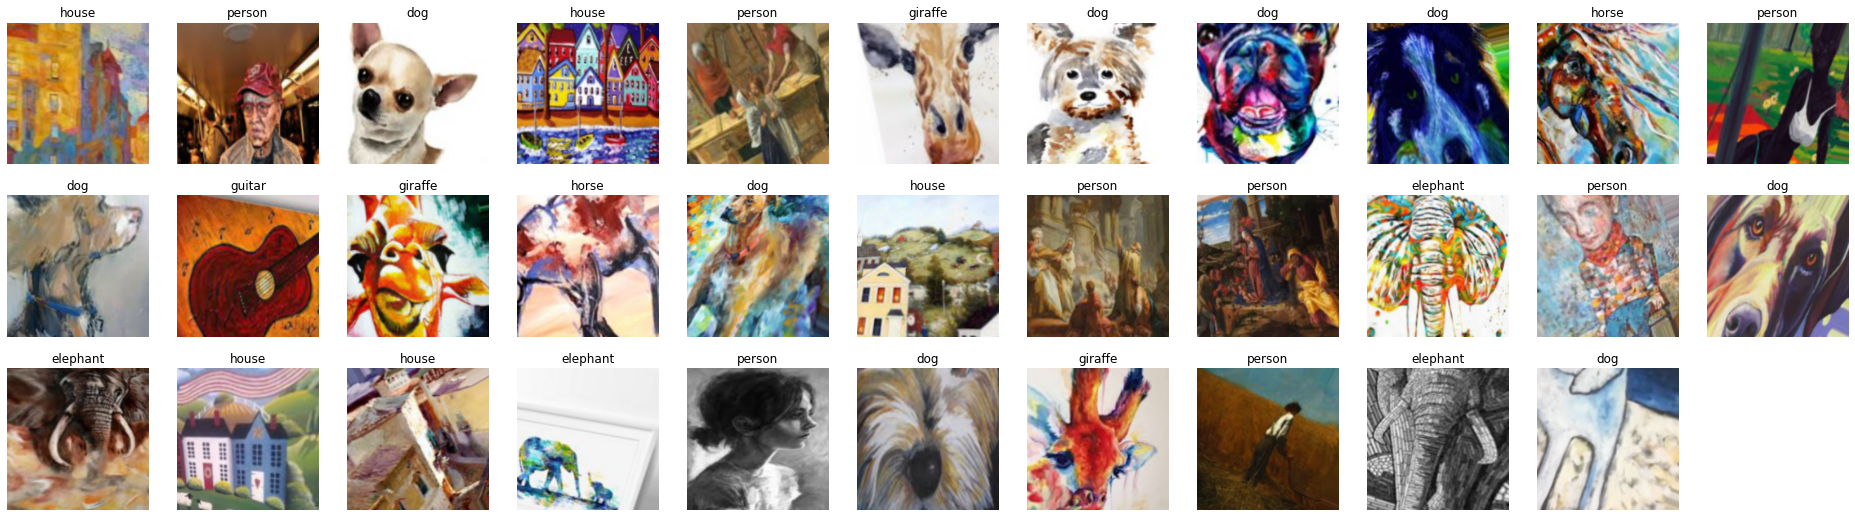

In [7]:
dls.train.show_batch(max_n= 32, nrows=3)

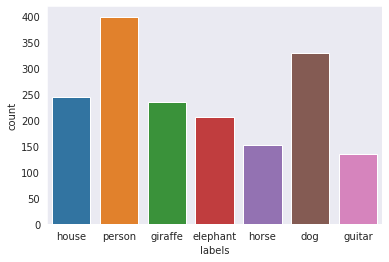

In [8]:
# 클래스 수 불균형 확인
sns.countplot(df_train.labels)
plt.show()

## 테스트 이미지 확인

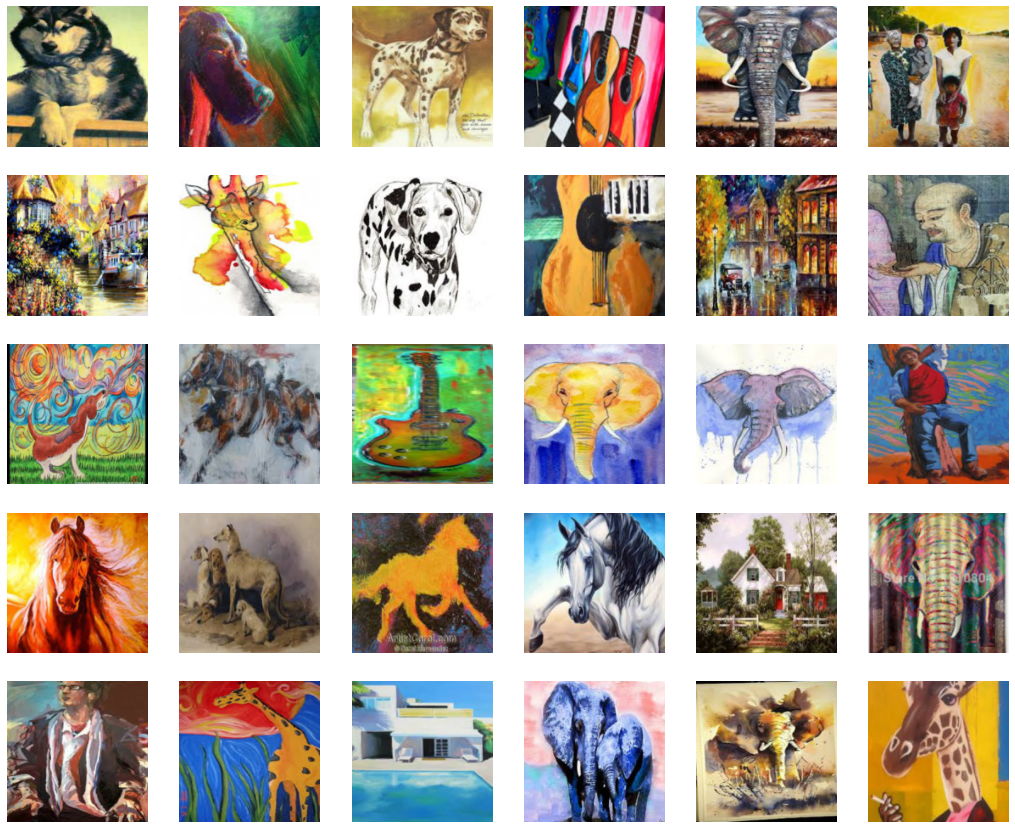

In [9]:
test_dsets = dls.test_dl(get_image_files('test/0'))
test_dsets.show_batch(max_n=30, nrows=5)

## 모델 선정 
  - efficientnetb0
  - lossfunc = BCEWithLogitsLossFlat
    - fastAI의 multicategory block을 사용하여 원-핫 인코딩이 되어있기 때문에 BCEWithLogitsLoss 를 사용
  - optimizer = adam

In [11]:
learn = cnn_learner(dls, efficientnet_b0, loss_func=BCEWithLogitsLossFlat(),
                    metrics=[accuracy_multi, F1ScoreMulti(thresh=0.5,average='macro', sample_weight=None)],
                    cbs=EarlyStoppingCallback(monitor='accuracy_multi', min_delta=config.min_delta, patience=config.patience))

### 첫번째 폴드 30 epochs test
  - 빠른 계산을 위해 fp16 사용하여 테스트

In [12]:
learn.to_fp16().fit_one_cycle(config.epochs, 3e-3)

No improvement since epoch 7: early stopping


In [22]:
learn = cnn_learner(dls, efficientnet_b0, loss_func=BCEWithLogitsLossFlat(),
                    metrics=[accuracy_multi, F1ScoreMulti(thresh=0.5,average='macro', sample_weight=None)],
                    cbs=EarlyStoppingCallback(monitor='accuracy_multi', min_delta=config.min_delta, patience=config.patience))

### learning rate 탐색 = 3e-3 그대로 사용

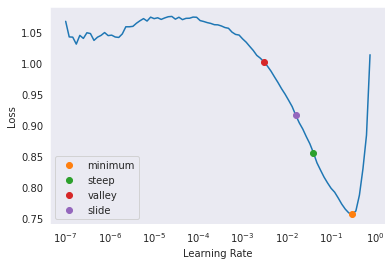

In [14]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [23]:
learn.to_fp16().fit_one_cycle(config.epochs, 3e-3)

No improvement since epoch 19: early stopping


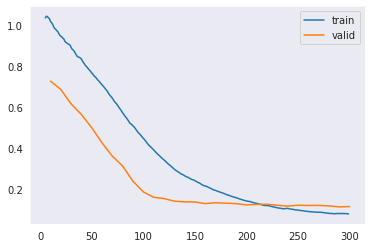

In [24]:
learn.recorder.plot_loss()

### 최적의 임계점 탐색 = 0.5 그대로 사용

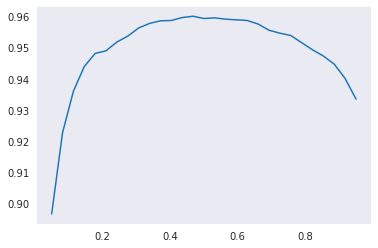

In [22]:
xs = torch.linspace(0.05, 0.95, 29)
preds, targs = learn.get_preds()
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

### 클래스 불균형을 완화
- 각 클래스에 가중치 부여 (가장 많은 클래스 수/클래스 수) 

In [7]:
cls_num = [df_train.labels.value_counts()[cls] for cls in dls.train.vocab]
cls_w = torch.FloatTensor(np.max(cls_num)/cls_num).cuda()
learn = cnn_learner(dls, efficientnet_b0,
                    metrics=[accuracy_multi, F1ScoreMulti(thresh=0.5,average='macro', sample_weight=None)],
                    cbs=EarlyStoppingCallback(monitor='accuracy_multi', min_delta=config.min_delta, patience=config.patience))
learn.crit = BCEWithLogitsLossFlat(weight=cls_w)

In [8]:
learn.to_fp16().fit_one_cycle(config.epochs, config.lr)

No improvement since epoch 12: early stopping


### CutMix, MixUp 추가
  - 모델을 robust 하게 하고 일반화 성능을 향상시키기 위해

In [11]:
learn = cnn_learner(dls, efficientnet_b0, loss_func=BCEWithLogitsLossFlat(),
                    metrics=[accuracy_multi, F1ScoreMulti(thresh=0.5,average='macro', sample_weight=None)],
                    cbs=[EarlyStoppingCallback(monitor='accuracy_multi', min_delta=config.min_delta, patience=config.patience), CutMix(), MixUp()])

In [12]:
learn.to_fp16().fit_one_cycle(config.epochs, config.lr)

No improvement since epoch 12: early stopping


In [9]:
cls_num = [df_train.labels.value_counts()[cls] for cls in dls.train.vocab]
cls_w = torch.FloatTensor(np.max(cls_num)/cls_num).cuda()
learn = cnn_learner(dls, efficientnet_b0,
                    metrics=[accuracy_multi, F1ScoreMulti(thresh=0.5,average='macro', sample_weight=None)],
                    cbs=[EarlyStoppingCallback(monitor='accuracy_multi', min_delta=config.min_delta, patience=config.patience), CutMix(), MixUp()])
learn.crit = BCEWithLogitsLossFlat(weight=cls_w)

In [10]:
learn.to_fp16().fit_one_cycle(config.epochs, config.lr)

No improvement since epoch 15: early stopping


#### CutMix만

In [11]:
cls_num = [df_train.labels.value_counts()[cls] for cls in dls.train.vocab]
cls_w = torch.FloatTensor(np.max(cls_num)/cls_num).cuda()
learn = cnn_learner(dls, efficientnet_b0,
                    metrics=[accuracy_multi, F1ScoreMulti(thresh=0.5,average='macro', sample_weight=None)],
                    cbs=[EarlyStoppingCallback(monitor='accuracy_multi', min_delta=config.min_delta, patience=config.patience), CutMix()])
learn.crit = BCEWithLogitsLossFlat(weight=cls_w)

In [12]:
learn.to_fp16().fit_one_cycle(config.epochs, config.lr)

No improvement since epoch 11: early stopping


#### MixUp만

In [13]:
cls_num = [df_train.labels.value_counts()[cls] for cls in dls.train.vocab]
cls_w = torch.FloatTensor(np.max(cls_num)/cls_num).cuda()
learn = cnn_learner(dls, efficientnet_b0,
                    metrics=[accuracy_multi, F1ScoreMulti(thresh=0.5,average='macro', sample_weight=None)],
                    cbs=[EarlyStoppingCallback(monitor='accuracy_multi', min_delta=config.min_delta, patience=config.patience), MixUp()])
learn.crit = BCEWithLogitsLossFlat(weight=cls_w)

In [14]:
learn.to_fp16().fit_one_cycle(config.epochs, config.lr)

No improvement since epoch 17: early stopping


## 최종모델
### 5 fold cross validation

In [ ]:
models = []
scores = []
for fold in range(config.num_fold):
    dls = get_dls(df_train, num_fold=fold, bs=32)
    cls_num = [df_train.labels.value_counts()[cls] for cls in dls.train.vocab]
    cls_w = torch.FloatTensor(np.max(cls_num)/cls_num).cuda()
    learn = cnn_learner(dls, efficientnet_b0,
                        metrics=[accuracy_multi, F1ScoreMulti(thresh=0.5,average='macro', sample_weight=None)],
                        cbs=EarlyStoppingCallback(monitor='accuracy_multi', min_delta=config.min_delta, patience=config.patience))
    learn.crit = BCEWithLogitsLossFlat(weight=cls_w)
    learn.to_fp16().fit_one_cycle(config.epochs, config.lr)
    preds, targs = learn.get_preds()
    acc = accuracy_multi(preds, targs)
    models.append(learn)
    scores.append(acc)

print(scores)
print(np.mean(scores))

No improvement since epoch 14: early stopping


No improvement since epoch 15: early stopping


No improvement since epoch 13: early stopping


No improvement since epoch 13: early stopping
